<h1 align="center">Eye Diseases Classification 👁️</h1>
<p style="text-align:center;">The dataset consists of Normal, Diabetic Retinopathy, Cataract, and Glaucoma retinal images, where each class has approximately 1000 images. These images are collected from various sources like IDRiD, Oculur recognition, HRF, etc.</p>

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall
from torchmetrics.functional import f1_score

from tqdm import tqdm

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load data

In [2]:
def load_data():
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )

    return datasets.ImageFolder(root="dataset", transform=t)

In [3]:
dataset = load_data()

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 4217
    Root location: dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
           )

In [5]:
# number of classes
NUMBER_OF_CLASSES = len(set(dataset.targets))

In [6]:
print(f"Number of classes: {NUMBER_OF_CLASSES}")

Number of classes: 4


### Exploring images

Label : cataract


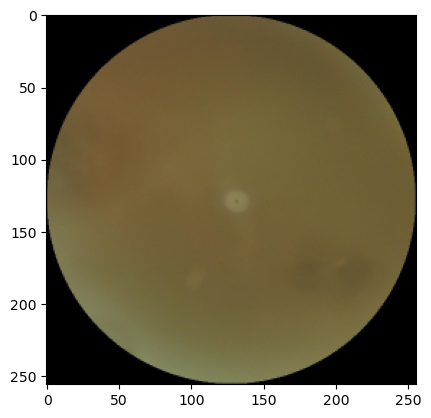

In [7]:
def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))


# display the first image in the dataset
display_image(*dataset[0])

## Split data into train-test

In [8]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset

In [9]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)

## DataLoader

In [10]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

### Visualizing the batch images

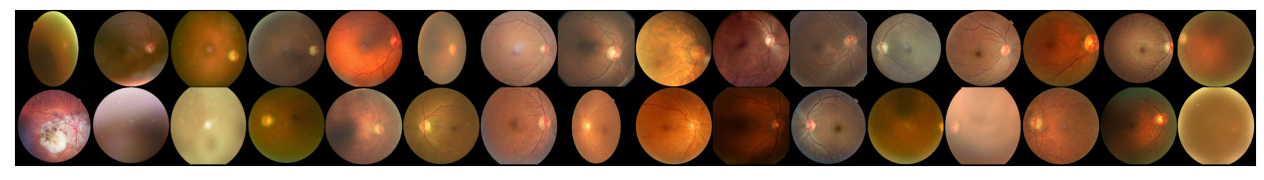

In [11]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dataloader)

## Convolutional neural network (CNN)

In [12]:
class CNN(nn.Module):
    def __init__(self, NUMBER_OF_CLASSES):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUMBER_OF_CLASSES),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x

In [13]:
model = CNN(NUMBER_OF_CLASSES)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Device configuration

In [15]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"

## Training function

In [18]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    model.to(device)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
    for epoch in range(epochs):
        train_loss = []
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss
        train_loss = np.mean(train_loss)
        # Train accuracy
        train_accuracy = accuracy(outputs, targets)

        test_loss = []
        for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get test loss
        test_loss = np.mean(test_loss)
        # Test accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(
            f"Validation Loss: {train_loss:.2f}, Validation Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses

In [19]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10
)

Validating... Epoch: 1/10: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Epoch 1/10: Train Loss: 0.89, Test Loss: 0.64,         Train Accuracy: 0.92, Test Accuracy: 0.83,


Validating... Epoch: 2/10: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Epoch 2/10: Train Loss: 0.65, Test Loss: 0.55,         Train Accuracy: 0.85, Test Accuracy: 0.83,


Validating... Epoch: 3/10: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Epoch 3/10: Train Loss: 0.57, Test Loss: 0.53,         Train Accuracy: 0.69, Test Accuracy: 0.75,


Training... Epoch: 4/10:   0%|          | 0/106 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/torch/__init_

Unexpected exception formatting exception. Falling back to standard exception


    from .. import functional as F
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/torch/nn/functional.py", line 19, in <module>
    _check_overload_body(func)

  File "/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/torch/_jit_internal.py", line 839, in _check_overload_body
    from .._jit_internal import boolean_dispatch, _overload, BroadcastingList1, BroadcastingList2, BroadcastingList3
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/torch/_jit_internal.py", line 39, in <module>
    import torch.distributed.rpc
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/torch/distributed/__init__.py", line 58, in <module>
    parsed_def = parse_def(func)
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/torch/_sources.py", line 122, in parse_def
    from ._diagnostic import (
  File "/Users/sinaraoufi/miniforge3/lib/python3.10/site-packages/torch/onnx/_internal/diagnostics/_diagnostic.py", line 7, in <module>
    fr

## Plot the losses

In [ ]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Predection

In [ ]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))

## Evaluations

### Confusion matrix

In [ ]:
confmat = ConfusionMatrix(num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)

In [ ]:
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()

### Accuracy

In [ ]:
accuracy = Accuracy(num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

### Precision & Recall

In [ ]:
precision, recall = precision_recall(preds, targets, average="macro", num_classes=NUMBER_OF_CLASSES)
print(f"Precision: {100 * precision:.2f}%, Recall: {100 * recall:.2f}%")

### F1-score

In [ ]:
f1_score = f1_score(preds, targets, num_classes=NUMBER_OF_CLASSES)
print(f"F1-score: {100 * f1_score:.2f}%")